# Depth Anything 3 (DA3) Usage with COLMAP Cameras Example

This notebook demonstrates how to extract camera intrinsics and extrinsics from COLMAP data and use them in Depth Anything 3 model inference for improved depth estimation.

In [ ]:
# Install required packages (if not already installed)
# !pip install depth-anything-3 numpy matplotlib pillow torch

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from depth_anything_3.api import DepthAnything3
from depth_anything_3.utils.visualize import visualize_depth

from depth_anything_3.utils.read_write_model import read_model
from depth_anything_3.utils.read_write_model import extract_intrinsics_extrinsics_from_colmap
from depth_anything_3.utils.read_write_model import get_image_paths

[WARN ] Dependency `gsplat` is required for rendering 3DGS. Install via: pip install git+https://github.com/nerfstudio-project/gsplat.git@0b4dddf04cb687367602c01196913cde6a743d70


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DepthAnything3.from_pretrained("depth-anything/DA3-LARGE")
model = model.to(device)
model.eval()
print(f"Model loaded on {device}")

config.json: 0.00B [00:00, ?B/s]

[INFO ] using MLP layer as FFN


model.safetensors:   0%|          | 0.00/1.64G [00:00<?, ?B/s]

Model loaded on cuda


In [ ]:
# Load COLMAP model
# The actual path to your COLMAP reconstruction directory
colmap_path = "C:\\Users\\path\\to\\colmap\\sparse\\0"  

assert os.path.exists(colmap_path), "COLMAP path does not exist. Please check the path."

cameras, images, points3D = read_model(colmap_path, ext=".txt")  # or ".bin"
print(f"Loaded COLMAP model with {len(cameras)} cameras, {len(images)} images, {len(points3D)} points")

# Extract intrinsics and extrinsics
intrinsics, extrinsics = extract_intrinsics_extrinsics_from_colmap(cameras, images)
print(f"Extracted intrinsics shape: {intrinsics.shape}")
print(f"Extracted extrinsics shape: {extrinsics.shape}")

# Get image paths from COLMAP images (assuming images are in the same directory or adjust paths)
image_paths = get_image_paths(images, colmap_path)


Loaded COLMAP model with 1 cameras, 68 images, 20825 points
Extracted intrinsics shape: (68, 3, 3)
Extracted extrinsics shape: (68, 4, 4)


In [26]:
intrinsics[0], extrinsics[0]

(array([[1.49228835e+03, 0.00000000e+00, 9.87000000e+02],
        [0.00000000e+00, 1.49228835e+03, 6.63000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[ 0.84980583,  0.51323723, -0.1200733 ,  0.28258488],
        [ 0.09022157, -0.36607422, -0.92620178,  5.19497268],
        [-0.51931697,  0.77625847, -0.35739708,  4.25870389],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [19]:
# Run inference with predicted intrinsics and extrinsics
prediction = model.inference(
    image=image_paths,
    process_res=504,
    process_res_method="upper_bound_resize",
    export_dir="./without",
    export_format="glb",
    num_max_points=5000000,
)
print(f"Depth shape: {prediction.depth.shape}")
print(f"Extrinsics: {prediction.extrinsics.shape if prediction.extrinsics is not None else 'None'}")
print(f"Intrinsics: {prediction.intrinsics.shape if prediction.intrinsics is not None else 'None'}")

[INFO ] Processed Images Done taking 0.649794340133667 seconds. Shape:  torch.Size([68, 3, 378, 504])
[INFO ] Model Forward Pass Done. Time: 2.6418516635894775 seconds
[INFO ] Conversion to Prediction Done. Time: 0.014819622039794922 seconds
[INFO ] Model Forward Pass Done. Time: 2.6418516635894775 seconds
[INFO ] Conversion to Prediction Done. Time: 0.014819622039794922 seconds
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 5000000
[INFO ] Exporting to GLB with num_max_points: 5000000
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 5000000
[INFO ] Exporting to GLB with num_max_points: 5000000
[INFO ] Export Results Done. Time: 4.059317588806152 seconds
Depth shape: (68, 378, 504)
Extrinsics: (68, 3, 4)
Intrinsics: (68, 3, 3)
[INFO ] Export Results Done. Time: 4.059317588806152 seconds
Depth shape: (68, 378, 504)
Extrinsics: (68, 3, 4)
Intrinsics: (68, 3, 3)


In [20]:
prediction.intrinsics[0], prediction.extrinsics[0]

(array([[328.46768,   0.     , 252.     ],
        [  0.     , 326.5554 , 189.     ],
        [  0.     ,   0.     ,   1.     ]], dtype=float32),
 array([[ 9.9999994e-01,  8.7640976e-05, -3.4635715e-04,  6.9517829e-04],
        [-8.7647131e-05,  1.0000000e+00, -1.7739199e-05, -1.3648468e-04],
        [ 3.4635558e-04,  1.7769557e-05,  9.9999994e-01,  7.3227980e-05]],
       dtype=float32))

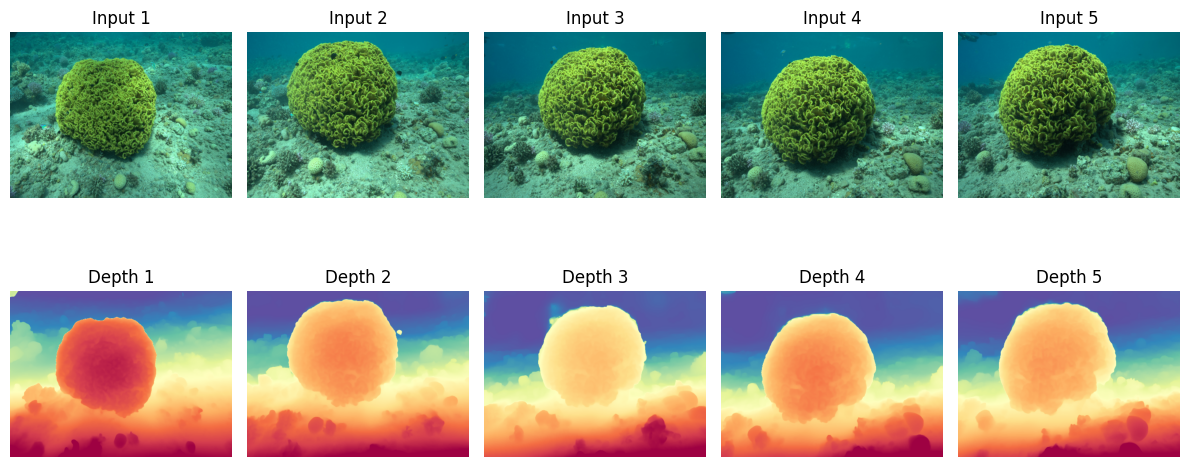

In [21]:
# Visualize input images and depth maps
n_images = 5

fig, axes = plt.subplots(2, n_images, figsize=(12, 6))

if n_images == 1:
    axes = axes.reshape(2, 1)

for i in range(n_images):
    # Show original image
    if prediction.processed_images is not None:
        axes[0, i].imshow(prediction.processed_images[i])
    axes[0, i].set_title(f"Input {i+1}")
    axes[0, i].axis('off')
    
    # Show depth map
    depth_vis = visualize_depth(prediction.depth[i], cmap="Spectral")
    axes[1, i].imshow(depth_vis)
    axes[1, i].set_title(f"Depth {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [22]:
# Run inference with custom intrinsics and extrinsics
prediction = model.inference(
    image=image_paths,
    intrinsics=intrinsics,  # Pass the extracted intrinsics
    extrinsics=extrinsics,  # Pass the extracted extrinsics
    process_res=504,
    process_res_method="upper_bound_resize",
    export_dir="./with",
    export_format="glb",
    num_max_points=5000000,

)
print(f"Depth shape: {prediction.depth.shape}")
print(f"Extrinsics: {prediction.extrinsics.shape if prediction.extrinsics is not None else 'None'}")
print(f"Intrinsics: {prediction.intrinsics.shape if prediction.intrinsics is not None else 'None'}")

[INFO ] Processed Images Done taking 0.690438985824585 seconds. Shape:  torch.Size([68, 3, 378, 504])
[INFO ] Using camera conditions provided by the user
[INFO ] Model Forward Pass Done. Time: 2.6054494380950928 seconds
[INFO ] Conversion to Prediction Done. Time: 0.016798973083496094 seconds
[INFO ] Model Forward Pass Done. Time: 2.6054494380950928 seconds
[INFO ] Conversion to Prediction Done. Time: 0.016798973083496094 seconds
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 5000000
[INFO ] Exporting to GLB with num_max_points: 5000000
[INFO ] conf_thresh_percentile: 40.0
[INFO ] num max points: 5000000
[INFO ] Exporting to GLB with num_max_points: 5000000
[INFO ] Export Results Done. Time: 3.964714527130127 seconds
Depth shape: (68, 378, 504)
Extrinsics: (68, 3, 4)
Intrinsics: (68, 3, 3)
[INFO ] Export Results Done. Time: 3.964714527130127 seconds
Depth shape: (68, 378, 504)
Extrinsics: (68, 3, 4)
Intrinsics: (68, 3, 3)


In [24]:
prediction.intrinsics[0], prediction.extrinsics[0]

(array([[350.4722 ,   0.     , 231.80243],
        [  0.     , 357.46832, 158.81749],
        [  0.     ,   0.     ,   1.     ]], dtype=float32),
 array([[ 0.84980583,  0.51323724, -0.1200733 ,  0.28258488],
        [ 0.09022157, -0.36607423, -0.92620176,  5.1949725 ],
        [-0.519317  ,  0.77625847, -0.35739708,  4.2587037 ]],
       dtype=float32))

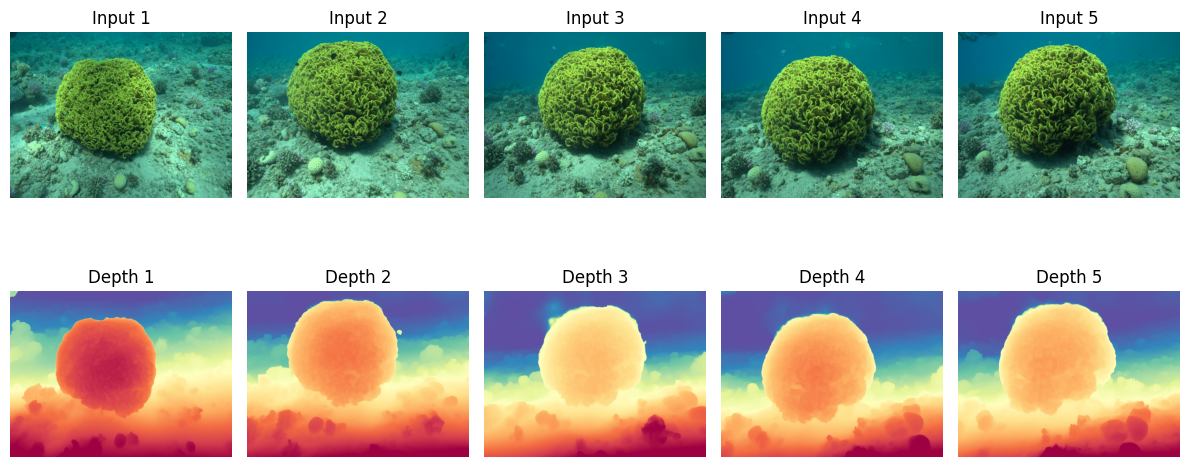

In [11]:
# Visualize input images and depth maps
n_images = 5

fig, axes = plt.subplots(2, n_images, figsize=(12, 6))

if n_images == 1:
    axes = axes.reshape(2, 1)

for i in range(n_images):
    # Show original image
    if prediction.processed_images is not None:
        axes[0, i].imshow(prediction.processed_images[i])
    axes[0, i].set_title(f"Input {i+1}")
    axes[0, i].axis('off')
    
    # Show depth map
    depth_vis = visualize_depth(prediction.depth[i], cmap="Spectral")
    axes[1, i].imshow(depth_vis)
    axes[1, i].set_title(f"Depth {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()